## Imports

In [243]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [244]:
df = pd.read_csv('combined_df.csv')

In [245]:
df_relevant = df[['Type', 'Genres', 'Category', 'Content Rating', 'Normal_Rating_Count', 'Normal_Rating','Normal_Reviews', 'Normal_Size', 'Normal_Installs', 'Normal_Price', 'Normal_Revenue', 'Normal_popularity']]

## Label Encoding for ordinal categorical data

In [246]:
label_encoder = LabelEncoder()
df_relevant['Content Rating'] = label_encoder.fit_transform(df_relevant['Content Rating'])
df_relevant['Genres'] = label_encoder.fit_transform(df_relevant['Genres'])
df_relevant['Category'] = label_encoder.fit_transform(df_relevant['Category'])

C:\Users\ewint\AppData\Local\Temp\ipykernel_9276\3702870009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Content Rating'] = label_encoder.fit_transform(df_relevant['Content Rating'])
C:\Users\ewint\AppData\Local\Temp\ipykernel_9276\3702870009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Genres'] = label_encoder.fit_transform(df_relevant['Genres'])
C:\Users\ewint\AppData\Local\Temp\ipykernel_9276\3702870009.py:4: SettingWithCopyWarning: 
A value is trying to be set on 

## One-Hot Encoding for nominal categorical data

In [247]:
# # Example using pandas get_dummies for nominal data
# df_relevant = pd.get_dummies(df_relevant, columns=['Genres', 'Category'], drop_first=False)
# for col in df_relevant.columns:
#     if 'Genres' in col or 'Category' in col:
#         df_relevant[col] = df_relevant[col].astype(int)

## Feature selection

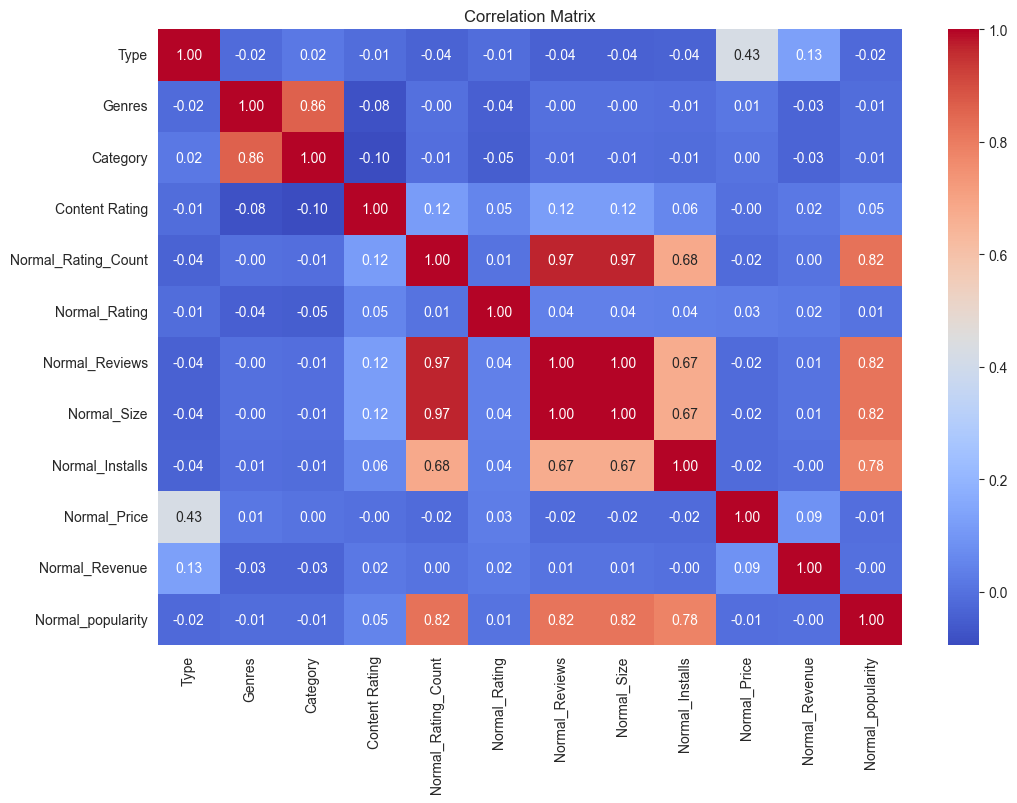

Relevant features based on correlation: ['Normal_Rating']


In [248]:
# Compute the correlation matrix
correlation_matrix = df_relevant.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Select features that have a high correlation with Normal_Rating
correlation_threshold = 0.1  # You can adjust this threshold
relevant_features = correlation_matrix.index[abs(correlation_matrix['Normal_Rating']) > correlation_threshold].tolist()

print("Relevant features based on correlation:", relevant_features)

so based on the result of the correlation, it appears that rating has low correlation with all other features, so it doesn't have strong linear relationship with others, so we should classify it using methods like decision tree or random forest (not linear regression).

## Convert normal_rating to ordinal categorical type to be able to use decision tree and random forest

In [249]:
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = [1, 2, 3, 4, 5]

df_relevant['Rating_Category'] = pd.cut(df_relevant['Normal_Rating'], bins=bin_edges, labels=bin_labels, include_lowest=True)
print(df_relevant['Rating_Category'].value_counts())

Rating_Category
5    4480
4    1143
3     518
2      64
1      45
Name: count, dtype: int64


C:\Users\ewint\AppData\Local\Temp\ipykernel_9276\105818674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Rating_Category'] = pd.cut(df_relevant['Normal_Rating'], bins=bin_edges, labels=bin_labels, include_lowest=True)


# Classification

## Split data

In [250]:
df_relevant = df_relevant.drop(columns=['Normal_Rating', 'Normal_popularity'])
features = df_relevant.drop(columns=['Rating_Category'])
targets = df_relevant['Rating_Category']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Standardize the features for SVM
scaler = StandardScaler()
X_train_Standard = scaler.fit_transform(X_train)
X_test_Standard = scaler.transform(X_test)

## Training the model

In [251]:
# Initialize the Classifier
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
# svm_model = SVC(random_state=42)
nb_model = GaussianNB() #naive_bayes

# # Train the model
# dt_model.fit(X_train, y_train)
# rf_model.fit(X_train, y_train)
# svm_model.fit(X_train_Standard, y_train)
# # Make predictions
# y_pred_dt = dt_model.predict(X_test)
# y_pred_rf = rf_model.predict(X_test)
# y_pred_svm = svm_model.predict(X_test_Standard)

### Hyperparameter tuning

#### Define hyperparameter grids

In [252]:
dt_param_grid = {
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

rf_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    # 'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [1, 3, 5],
    # 'bootstrap': [True, False]
}

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

# svm_param_grid = {
#     'C': [0.1, 1, 10, 100,],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf','linear']
# }


#### Initialize GridSearchCV

In [253]:
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
nb_grid_search = GridSearchCV(nb_model, nb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

#### Train the models

In [254]:
print("Training Decision Tree...")
dt_grid_search.fit(X_train, y_train)

print("Training Random Forest...")
rf_grid_search.fit(X_train, y_train)

print("Training Naive Bayes...")
nb_grid_search.fit(X_train, y_train)

# print("Training SVM...")
# svm_grid_search.fit(X_train_Standard, y_train)


Training Decision Tree...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Training Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01]},
             scoring='accuracy', verbose=1)

In [255]:
score_df_dt = pd.DataFrame(dt_grid_search.cv_results_)
score_df_dt.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.066813,0.019433,0.015154,0.018258,entropy,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.790,0.794,0.788,0.788,0.795,0.7910,0.002966,1
10,0.030033,0.002256,0.009065,0.003995,gini,5,5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.785,0.801,0.790,0.790,0.779,0.7890,0.007239,2
42,0.034379,0.001194,0.006470,0.001431,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.790,0.792,0.793,0.783,0.783,0.7882,0.004354,3
37,0.037452,0.009980,0.012997,0.015181,entropy,3,20,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.793,0.790,0.788,0.785,0.782,0.7876,0.003826,4
38,0.051572,0.019765,0.006088,0.001779,entropy,3,50,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.793,0.790,0.788,0.785,0.782,0.7876,0.003826,4


In [256]:
score_df_rf = pd.DataFrame(rf_grid_search.cv_results_)
score_df_rf.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,2.896670,0.669725,0.068679,0.023949,20,1,5,100,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.833,0.812,0.822,0.820,0.822,0.8218,0.006705,1
75,5.727614,0.195398,0.118944,0.032780,20,1,5,250,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.832,0.815,0.823,0.819,0.819,0.8216,0.005783,2
110,6.170412,0.158817,0.171992,0.041454,25,1,5,200,"{'max_depth': 25, 'min_samples_leaf': 1, 'min_...",0.827,0.816,0.824,0.817,0.823,0.8214,0.004224,3
108,2.920305,0.124115,0.071079,0.014089,25,1,5,100,"{'max_depth': 25, 'min_samples_leaf': 1, 'min_...",0.827,0.808,0.825,0.822,0.824,0.8212,0.006794,4
109,4.424227,0.159967,0.097100,0.003023,25,1,5,150,"{'max_depth': 25, 'min_samples_leaf': 1, 'min_...",0.830,0.811,0.822,0.819,0.823,0.8210,0.006164,5


In [257]:
score_df_nb = pd.DataFrame(nb_grid_search.cv_results_)
score_df_nb.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.014345,0.001764,0.012302,0.002829,0.0001,{'var_smoothing': 0.0001},0.718,0.717,0.717,0.717,0.717,0.7172,0.000400,1
6,0.019065,0.009728,0.010701,0.003300,0.001,{'var_smoothing': 0.001},0.718,0.717,0.717,0.717,0.717,0.7172,0.000400,1
7,0.016285,0.002812,0.010940,0.005077,0.01,{'var_smoothing': 0.01},0.718,0.717,0.717,0.717,0.717,0.7172,0.000400,1
4,0.014600,0.001995,0.014619,0.004858,0.00001,{'var_smoothing': 1e-05},0.666,0.676,0.671,0.683,0.681,0.6754,0.006280,4
3,0.015565,0.004367,0.014180,0.009209,0.000001,{'var_smoothing': 1e-06},0.200,0.130,0.193,0.181,0.191,0.1790,0.025243,5


In [258]:
# score_df_svm = pd.DataFrame(svm_grid_search.cv_results_)
# score_df_svm.nlargest(5, "mean_test_score")

#### Get the best models

In [259]:
best_dt_model = dt_grid_search.best_estimator_
print(best_dt_model)
best_rf_model = rf_grid_search.best_estimator_
print(best_rf_model)
best_nb_model = nb_grid_search.best_estimator_
print(best_nb_model)
# best_svm_model = svm_grid_search.best_estimator_
# print(best_svm_model)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=42)
GaussianNB(var_smoothing=0.0001)


#### Make predictions

In [260]:
y_pred_dt = best_dt_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)
y_pred_nb = best_nb_model.predict(X_test)
# y_pred_svm = best_svm_model.predict(X_test_Standard)

## Evaluate the model

Decision Tree - train_acc: 0.78
Decision Tree - Accuracy: 0.78
Decision Tree - Precision: 0.8149759408602151
Decision Tree - Recall: 0.78
Decision Tree - F1 Score: 0.7065606672132407


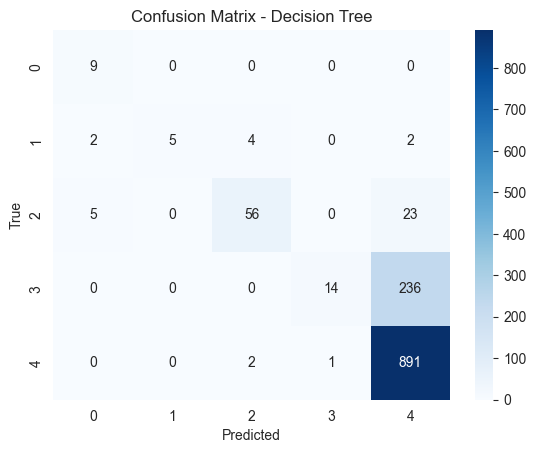

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           1       0.56      1.00      0.72         9
           2       1.00      0.38      0.56        13
           3       0.90      0.67      0.77        84
           4       0.93      0.06      0.11       250
           5       0.77      1.00      0.87       894

    accuracy                           0.78      1250
   macro avg       0.83      0.62      0.60      1250
weighted avg       0.81      0.78      0.71      1250

Random Forest - train_acc: 0.8296
Random Forest - Accuracy: 0.8296
Random Forest - Precision: 0.8211717265122072
Random Forest - Recall: 0.8296
Random Forest - F1 Score: 0.8096998464006129


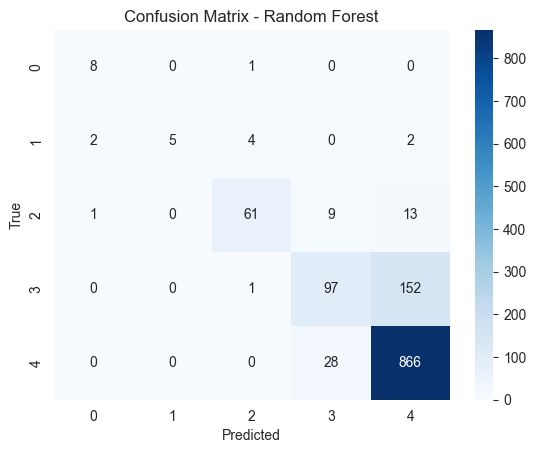

Classification Report - Random Forest:
              precision    recall  f1-score   support

           1       0.73      0.89      0.80         9
           2       1.00      0.38      0.56        13
           3       0.91      0.73      0.81        84
           4       0.72      0.39      0.51       250
           5       0.84      0.97      0.90       894

    accuracy                           0.83      1250
   macro avg       0.84      0.67      0.71      1250
weighted avg       0.82      0.83      0.81      1250

Decision Tree - train_acc: 0.7152
Decision Tree - Accuracy: 0.7152
Decision Tree - Precision: 0.5115110399999999
Decision Tree - Recall: 0.7152
Decision Tree - F1 Score: 0.596444776119403


C:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


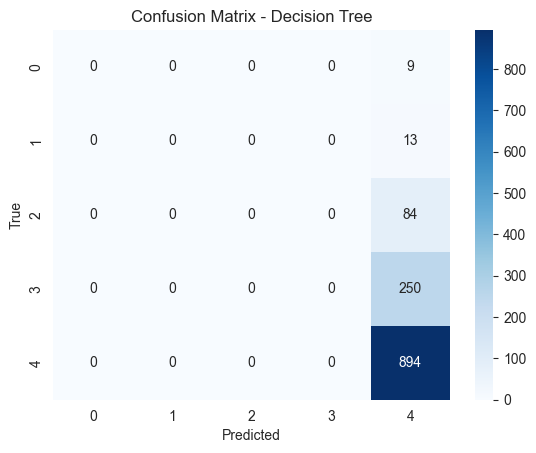

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        84
           4       0.00      0.00      0.00       250
           5       0.72      1.00      0.83       894

    accuracy                           0.72      1250
   macro avg       0.14      0.20      0.17      1250
weighted avg       0.51      0.72      0.60      1250



C:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [261]:
def evaluate_model(y_test, y_pred, model_name):
    train_acc = accuracy_score(y_train, best_dt_model.predict(X_train))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} - train_acc: {accuracy}")
    print(f"{model_name} - Accuracy: {accuracy}")
    print(f"{model_name} - Precision: {precision}")
    print(f"{model_name} - Recall: {recall}")
    print(f"{model_name} - F1 Score: {f1}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_report = classification_report(y_test, y_pred)
    print(f'Classification Report - {model_name}:\n{class_report}')

# Evaluate Decision Tree
evaluate_model(y_test, y_pred_dt, 'Decision Tree')

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, 'Random Forest')

# Evaluate Naive Bayes
evaluate_model(y_test, y_pred_nb, 'Decision Tree')

# Evaluate SVM
# evaluate_model(y_test, y_pred_svm, 'SVM')
